### Polynomial regression on the confirmed cases of COVID19 time series dataset
22/03/2020

In an outbreak of an infectious disease it is important to not only study the number of deaths, but also the growth rate of the number of people that get infected by the pathogen, in order to have a clear image of the state of the pandemic. Due to global deficiency in clinical tests that verify whether an individual is infected or not from the corona virus, it is essential to develop tools that can accurately assess the state of the pandemic.

Time series data from different countries (China, South Korea, Japan, Italy, Spain, France, UK, Germany, Netherlands, USA, and Greece) retrieved from the kaggle website ("Novel Corona Virus 2019 Dataset", 2020 https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) were used in order to identify the optimal model from the simple parametric family of polynomials (with degree up to 9).

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import operator
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot

The data_prep() function takes as input:

a dataset: a dataframe with columns the different countries and rows the confirmed cases of each date,

a country: the wanted column of the dataframe,

final_date: the number of dates from the end of the dataset that we want to exclude, f.ex if our dataset has entries until the 23/3/2020 and we want to stop our analysis on the 20/3/2020, we exclude 3 days (final_date=3).

The data_prep() function returns the dates as date counts (integers) (x axis) and the confirmed counts of each date (y axis), as numpy.ndarrays, in order to do polynomial regression.

In [2]:
def data_prep(dataset, country, final_date):

    dates_to_num = []      # convert the dates to integers 
    for i in range(len(dataset.index)-final_date):
        dates_to_num.append(i)      # exclude dates from the end
    dates_to_num = np.asarray(dates_to_num)      # transform to class 'numpy.ndarray'
    
    y = dataset[country].tolist()
    y = y[:-final_date]      # exclude the counts of the excluded dates    
    y = np.asarray(y)      # transform to class 'numpy.ndarray'

    # transform the data to include another axis --> numpy.ndarray
    x = dates_to_num[:, np.newaxis]
    y = y[:, np.newaxis]
    
    return (x, y)   

### Polynomial regression 

The polynomialRegression() function takes as input the country name, the x, y outputs of the previous function, the degree of the polynomial curve that we want to fit our data. 

The polynomialRegression() function returns the value of the BIC criterion of the selected model and the root mean square error of the test set (to test for overfitting).

In [3]:
def polynomialRegression(country, x, y, pol_degree, final_date):
    
    # split the dataset to train set (2/3) and test set (1/3)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)
    
    # use sklearn to generate polynomials
    polynomial_features= PolynomialFeatures(degree=pol_degree)
    xp_train = polynomial_features.fit_transform(X_train)
    xp_test = polynomial_features.fit_transform(X_test)
    
    # regression on polynomials using statsmodel OLS
    model = sm.OLS(y_train,xp_train).fit()       # OLS(y, X) method takes as an input two array-like objects
    y_test_pred = model.predict(xp_test) 
    
    # calculate the root mean square error of the test set
    rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
    
    return (model.rsquared, model.rsquared_adj, model.bic, rmse)   

Once we have identified the optimal model, the polRegr_plot() function plots the dataset and the regression line and predicts the count of identified cases of future dates.

In [4]:
def polRegr_plot(country, pol_degree, final_date, future_days):

    future_days = np.asarray(future_days)   
    future_days = future_days[:, np.newaxis]   

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

    polynomial_features= PolynomialFeatures(degree=pol_degree)
    xp_train = polynomial_features.fit_transform(X_train)
    xp_test = polynomial_features.fit_transform(X_test)
    xp_predict = polynomial_features.fit_transform(future_days)    

    model = sm.OLS(y_train,xp_train).fit()
    ypred = model.predict(xp_train) 
    y_test_pred = model.predict(xp_test) 
    cases_pred = model.predict(xp_predict)   
    
    ########## Plotting ##########

    # List of all the dates we have data plus the dates we have predicted (as timestamps)
    dates = dataset.index[0:-final_date]
    date_series = dates[0] + pd.to_timedelta(np.arange(  len(dates) + len(future_days)  ), 'D')
    # Convert the time stamps into a list of strings
    dates_asstr = []
    for item in date_series:
        date = item.strftime("%d-%b")
        dates_asstr.append(date)
    # The dates used for labeling the twin axis (in approximation to give the general idea)
    dates_aslabels = [dates_asstr[0],dates_asstr[12],dates_asstr[25],dates_asstr[40],dates_asstr[53],dates_asstr[-1]]    
        
    #Setup a host axis
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(bottom=0.1)  
    #Add twin y axis with offset from bottom and hide top axis
    par = host.twiny()
    new_fixed_axis = host.get_grid_helper().new_fixed_axis
    par.axis["bottom"] = new_fixed_axis(loc="bottom", axes=par, offset=(0, -40))
    par.axis["top"].set_visible(False)
    par.axis["bottom"].major_ticklabels.set_rotation(20)        

    # Create legend
    blue_dot = mlines.Line2D([], [], color='b', marker='.', markersize=10, label='Train set')
    red_dot = mlines.Line2D([], [], color='r', marker='.', markersize=10, label='Test set')
    purple_dot = mlines.Line2D([], [], color='purple', marker='.', markersize=10, label='Future predictions')
    plt.legend(handles=[blue_dot, red_dot, purple_dot])
    
    
    plt.scatter(X_train, y_train, s=10, c='b')    # the training set ponts
    plt.scatter(X_test, y_test, s=10, c='r')    # the test set points
    
    # Regression line (sort the values of x before line plot)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X_train,ypred), key=sort_axis)
    X_train, ypred = zip(*sorted_zip)

    plt.scatter(future_days,  cases_pred , s=10, c='purple')    # the predicted points

    plt.title('Polynomial of degree ' + str(pol_degree) + ', ' + country)
    plt.ylabel('Confirmed cases')
    plt.xlabel('Number of days from: ' + dates_asstr[0])
    plt.plot(X_train, ypred, color='m')
    par.set_xlabel("Dates")
    par.set_xticklabels(dates_aslabels, fontsize=0.20)
    
    #plt.savefig(country + str(pol_degree) + '.png')    # the plot can be saved in a png file
    plt.draw()
    plt.show()
    
    return (model.summary(), cases_pred)

#### Selection of the optimal model from polynomials of degree up to M=9, that best characterizes the growth curve of COVID-19 cases.

In [5]:
# Import the time_series_covid_19_confirmed.csv file as dataframe
# The Country/Region column is selected as the index of each row
data_input = pd.read_csv('time_series_covid_19_confirmed.csv',index_col='Country/Region')    

# Transpose the matrix and remove the columns Province/State, Lat, Long 
data_input = data_input.transpose().iloc[3:,:]  

# The dates are the index of each row, convert the dates to DatetimeIndex format
data_input.index = pd.to_datetime(data_input.index)
dataset = data_input.groupby(data_input.columns, axis=1).sum()    # sum the colums with the same name



countries = ['China','Korea, South','Japan','Italy','Spain','France','United Kingdom','Germany','Netherlands','US','Greece']
out_data = {}
for country in countries:
    x, y = data_prep(dataset, country, final_date = 3)      
    statistics_list = []
    for i in range(1,10):
        r_sqrt, r_sqrt_adj, bic, rmse = polynomialRegression(country, x, y, pol_degree = i, final_date = 3)     
        statistics_list.append( (  round(r_sqrt,3), round(r_sqrt_adj,3), round(bic,2), round(rmse,2)  ) )
    out_data[country] = statistics_list
        
Polynomial_degree = ['degree 1','degree 2','degree 3','degree 4','degree 5','degree 6','degree 7','degree 8','degree 9']
final_df = pd.DataFrame(out_data,index=Polynomial_degree )
final_df.to_excel('OLS_stats.xlsx')      # print table in exel file

The R-suared, the adj. R-squared, the BIC criterion and the root mean square error of polynomials of degree up to 9 for each selected country are printed out in the file: OLS_stats.xlsx.

#### Visualization of the data and  future predictions

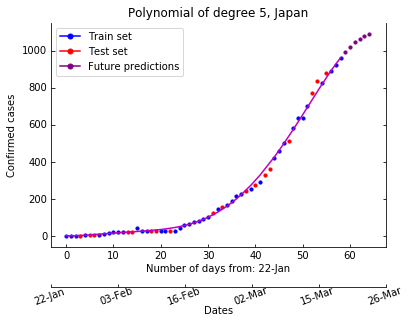

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.999
 Model:                            OLS   Adj. R-squared:                  0.999
 Method:                 Least Squares   F-statistic:                     5580.
 Date:                Tue, 15 Mar 2022   Prob (F-statistic):           9.96e-50
 Time:                        14:50:04   Log-Likelihood:                -154.30
 No. Observations:                  41   AIC:                             320.6
 Df Residuals:                      35   BIC:                             330.9
 Df Model:                           5                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [6]:
country = 'Japan'   #### Choose the name of the country
pol_degree = 5      #### Choose the degree of the polynomial
final_date = 3      #### Choose until which day (from the end of the dataset) you want to work with
future_days = [59, 60, 61, 62, 63, 64]     # we have data from day 0: 22/1/20 until day 58: 20/1/20 (in total 59 dates)

x, y = data_prep(dataset, country, final_date)
polRegr_plot(country, pol_degree, final_date, future_days)